In [1]:
import os
import numpy as np
import imageio

In [2]:
raw_path = '/Users/jiaor17/Desktop/pyt/md17/raw'

In [3]:
molecule_files = dict(
    Aspirin="aspirin_dft.npz",
    Benzene="benzene2017_dft.npz",
    Ethanol="ethanol_dft.npz",
    Malonaldehyde="malonaldehyde_dft.npz",
    Naphthalene="naphthalene_dft.npz",
    Salicylic_acid="salicylic_dft.npz",
    Toluene="toluene_dft.npz",
    Uracil="uracil_dft.npz",
)

In [4]:
tar_mol = 'Aspirin'

In [5]:
npz_file = np.load(os.path.join(raw_path, molecule_files[tar_mol]))

In [6]:
dic = {1:'H', 6: 'C', 8:'O', 7:'N'}

In [7]:
from xyz2mol import *

In [8]:
mols = xyz2mol(npz_file['z'].tolist(), npz_file['R'][0].tolist(),
               charge=0,
               use_graph=True,
               allow_charged_fragments=True,
               embed_chiral=True,
               use_huckel=False)

In [9]:
example_mol = mols[0]

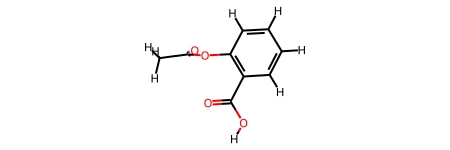

In [10]:
example_mol

In [11]:
def set_rdmol_positions(rdkit_mol, pos):
    """
    Args:
        rdkit_mol:  An `rdkit.Chem.rdchem.Mol` object.
        pos: (N_atoms, 3)
    """
    mol = copy.deepcopy(rdkit_mol)
    set_rdmol_positions_(mol, pos)
    return mol


def set_rdmol_positions_(mol, pos):
    """
    Args:
        rdkit_mol:  An `rdkit.Chem.rdchem.Mol` object.
        pos: (N_atoms, 3)
    """
    for i in range(pos.shape[0]):
        mol.GetConformer(0).SetAtomPosition(i, pos[i].tolist())
    return mol

In [12]:
from rdkit.Chem import PyMol

Run 'pymol -R' in Bash before the following block to start PyMol first. 

In [13]:
v = PyMol.MolViewer()

## Settings in PyMol

Display -> Background -> White

Display -> Color Space -> CMYK

Setting -> Lines & Sticks -> Ball and Stick

Setting -> Lines & Sticks -> Ball and Stick Ratio -> 1.5

(PyMol>) set stick_radius=0.15

In [14]:
from PIL import Image, ImageDraw, ImageFont

In [15]:
def cuthead(img, size=10):
    im = np.array(img)
    cutspace = im[:size,:,:]
    cvs = np.ones_like(cutspace) * 255
    im[:size,:,:] = cvs   
    img2 = Image.fromarray(im).convert('RGB')
    return img2

In [16]:
def add_caption(img, molecule, method, step, mae = None, fontsize=20):
    ime = ImageDraw.Draw(img)
    ft = ImageFont.truetype("times.ttf",size=fontsize)
    ime.text((10,10),f"{molecule}, {method}",(0,0,0),font=ft)
    if mae is not None:
        ime.text((10,15+fontsize),f"Step={step}, MAE={mae:.4f}",(0,0,0),font=ft)
    else:
        ime.text((10,15+fontsize),f"Step={step}",(0,0,0),font=ft)

In [17]:
# Visualize the example
v.ShowMol(example_mol)
v.server.do("color yellow, elem c")
v.server.do("color orange, elem h")
v.server.do("color blue, elem n")
v.server.do("color red, elem o")
img = v.GetPNG(h=300)
# You may adjust the view in PyMol for better visualization
img = cuthead(img)
add_caption(img, tar_mol, 'Example', 0, mae = 0.0, fontsize = 15)

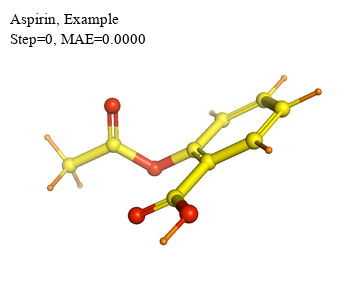

In [18]:
img

In [19]:
os.makedirs('vis',exist_ok=True)

In [20]:
from tqdm import tqdm

In [21]:
def get_traj_images(traj, molecule, method, mae = None):
    imgs = []
    last_pos = traj[0]
    for i in tqdm(range(1000)):
        pos = traj[i]
        mol = set_rdmol_positions(example_mol, pos)
        v.ShowMol(mol)
        v.server.do("color yellow, elem c")
        v.server.do("color orange, elem h")
        v.server.do("color blue, elem n")
        v.server.do("color red, elem o")
        img = v.GetPNG(h=300)
        img = cuthead(img)
        if mae is not None:
            tmp_mae = mae[i]
        else:
            tmp_mae = None
        add_caption(img, molecule, method, i + 1, tmp_mae, fontsize=15)
        imgs.append(img)
    return imgs

In [22]:
# From Ground Truth
traj_gt = npz_file['R'][10002:11002]

In [23]:
imgs = get_traj_images(traj_gt, tar_mol, "Ground Truth")

100%|██████████████████████████████████████████████████████████████| 1000/1000 [08:04<00:00,  2.06it/s]


In [24]:
out = imageio.mimsave(
            f'vis/{tar_mol}_GT_1000.gif',
            imgs, fps=50)

In [25]:
# From Generated Pickle File
import pickle as pkl
path = '../vel_1_pred_1_eval1000'
method = 'EGNN_DifferentialVector'
with open(os.path.join(path, method, tar_mol,'eval_result.pkl'),'rb') as f:
    trajs = pkl.load(f)
traj_pred = trajs[1][0]
traj_mae = trajs[0][0]

In [26]:
method_to_show=' '.join(method.split('_'))
method_to_show

'EGNN DifferentialVector'

In [28]:
imgs = get_traj_images(traj_gt, tar_mol, method_to_show, mae = traj_mae)

100%|██████████████████████████████████████████████████████████████| 1000/1000 [09:03<00:00,  1.84it/s]


In [29]:
out = imageio.mimsave(
            f'vis/{tar_mol}_{method_to_show}_1000.gif',
            imgs, fps=50)